# Crypto Currencies Predictions with LSTM

- https://steemit.com/python/@marketstack/how-to-download-historical-price-data-from-binance-with-python
- https://medium.com/better-programming/easiest-way-to-use-the-bitmex-api-with-python-fbf66dc38633
- https://sammchardy.github.io/binance/2018/01/08/historical-data-download-binance.html
- https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/
- https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

```
pip install python-binance
pip install keras
```

In [8]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python
import matplotlib.pyplot as plt # for charts and such
from datetime import datetime  # for dealing with times
import dateparser
import pytz
import time
from binance.client import Client

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import array
from keras.models import load_model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

Text(0, 0.5, 'USD')

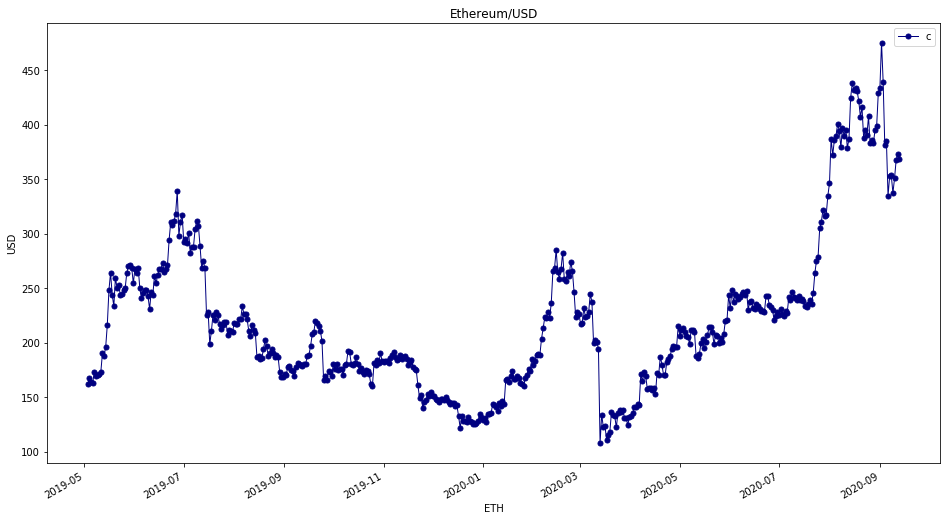

In [16]:
# This is one way to get ETH - USD data
def get_bars(symbol, interval = '1d'):
   root_url = 'https://api.binance.com/api/v3/klines'
   url = root_url + '?symbol=' + symbol + '&interval=' + interval
   data = json.loads(requests.get(url).text)
   df = pd.DataFrame(data)
   df.columns = ['open_time',
                 'o', 'h', 'l', 'c', 'v',
                 'close_time', 'qav', 'num_trades',
                 'taker_base_vol', 'taker_quote_vol', 'ignore']
   df.index = [datetime.fromtimestamp(x/1000.0) for x in df.close_time]
   return df

steemeth = get_bars('STEEMETH')
ethusdt = get_bars('ETHUSDT')
ethusdt_c = ethusdt['c'].astype('float')
steemusdt = steemeth['c'].astype('float') * ethusdt['c'].astype('float')

ax = ethusdt_c.plot(lw=1, colormap='jet', marker='.', markersize=10,figsize=(16,9),x='ETH',y='USD',legend=True,title='Ethereum/USD')
ax.set_xlabel("ETH")
ax.set_ylabel("USD")

In [17]:
# Fetch full crypto data from Binance
def date_to_milliseconds(date_str):
    """Convert UTC date to milliseconds
    If using offset strings add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    See dateparse docs for formats http://dateparser.readthedocs.io/en/latest/
    :param date_str: date in readable format, i.e. "January 01, 2018", "11 hours ago UTC", "now UTC"
    :type date_str: str
    """
    # get epoch value in UTC
    epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
    # parse our date string
    d = dateparser.parse(date_str)
    # if the date is not timezone aware apply UTC timezone
    if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
        d = d.replace(tzinfo=pytz.utc)

    # return the difference in time
    return int((d - epoch).total_seconds() * 1000.0)

def interval_to_milliseconds(interval):
    """Convert a Binance interval string to milliseconds
    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str
    :return:
         None if unit not one of m, h, d or w
         None if string not in correct format
         int value of interval in milliseconds
    """
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }

    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

def get_historical_klines(symbol, interval, start_str, end_str=None):
    """Get Historical Klines from Binance
    See dateparse docs for valid start and end string formats http://dateparser.readthedocs.io/en/latest/
    If using offset strings for dates add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    :param symbol: Name of symbol pair e.g BNBBTC
    :type symbol: str
    :param interval: Binance Kline interval
    :type interval: str
    :param start_str: Start date string in UTC format
    :type start_str: str
    :param end_str: optional - end date string in UTC format
    :type end_str: str
    :return: list of OHLCV values
    """
    # create the Binance client, no need for api key
    client = Client("", "")

    # init our list
    output_data = []

    # setup the max limit
    limit = 1000

    # convert interval to useful value in seconds
    timeframe = interval_to_milliseconds(interval)

    # convert our date strings to milliseconds
    start_ts = date_to_milliseconds(start_str)

    # if an end time was passed convert it
    end_ts = None
    if end_str:
        end_ts = date_to_milliseconds(end_str)

    idx = 0
    # it can be difficult to know when a symbol was listed on Binance so allow start time to be before list date
    symbol_existed = False
    while True:
        # fetch the klines from start_ts up to max 500 entries or the end_ts if set
        temp_data = client.get_klines(
            symbol=symbol,
            interval=interval,
            limit=limit,
            startTime=start_ts,
            endTime=end_ts
        )

        # handle the case where our start date is before the symbol pair listed on Binance
        if not symbol_existed and len(temp_data):
            symbol_existed = True

        if symbol_existed:
            # append this loops data to our output data
            output_data += temp_data

            # update our start timestamp using the last value in the array and add the interval timeframe
            start_ts = temp_data[len(temp_data) - 1][0] + timeframe
        else:
            # it wasn't listed yet, increment our start date
            start_ts += timeframe

        idx += 1
        # check if we received less than the required limit and exit the loop
        if len(temp_data) < limit:
            # exit the while loop
            break

        # sleep after every 3rd call to be kind to the API
        if idx % 3 == 0:
            time.sleep(1)

    return output_data

In [19]:
klines = get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2017")
df = pd.DataFrame(klines)
df.columns = ['open_time',
             'o', 'h', 'l', 'c', 'v',
             'close_time', 'qav', 'num_trades',
             'taker_base_vol', 'taker_quote_vol', 'ignore']
df.index = [datetime.fromtimestamp(x/1000.0) for x in df.close_time]

Text(0, 0.5, 'USD')

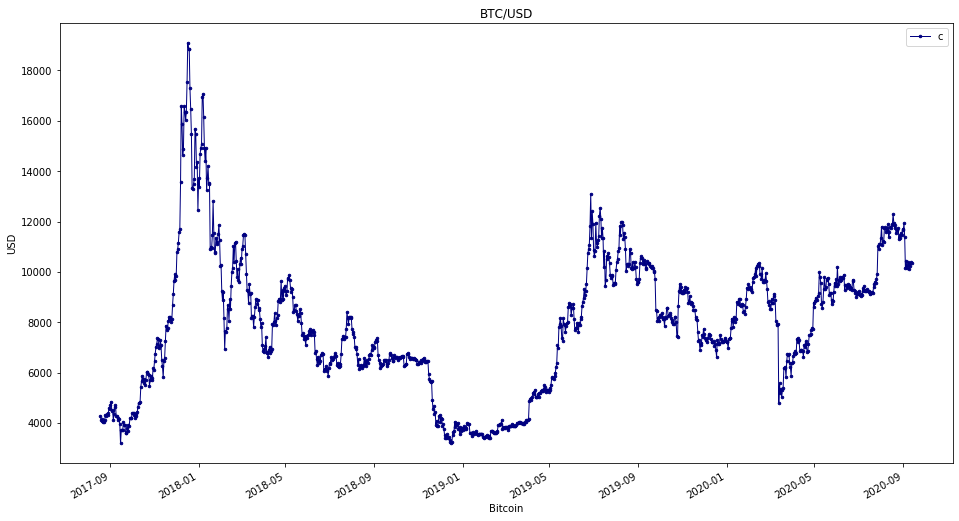

In [20]:
df_c = df['c'].astype('float')
ax = df_c.plot(lw=1, colormap='jet', marker='.', markersize=5,figsize=(16,9),legend=True,title='BTC/USD')
ax.set_xlabel("Bitcoin")
ax.set_ylabel("USD")

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

- *Samples*. One sequence is one sample. A batch is comprised of one or more samples.
- *Time Steps*. One time step is one point of observation in the sample.
- *Features*. One feature is one observation at a time step.

In [56]:
# Test data
X = df['c'].astype('float').to_numpy().reshape((1, 1123, 1))
y = df['c'].astype('float').to_numpy().reshape((1, 1123, 1))
print(X)

[[[ 4285.08]
  [ 4108.37]
  [ 4139.98]
  ...
  [10336.87]
  [10387.89]
  [10336.43]]]


In [57]:
# define model
model = Sequential()
model.add(LSTM(10, input_shape=(1123,1))) # 1123 time step, 1 feature
model.add(Dense(1, activation='linear')) # 1 or more samples
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [58]:
# compile model
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=300, shuffle=False, verbose=0)
# save model to single file
# later, perhaps run from another script
model.save('lstm_model.h5')

In [59]:
# load model from single file
model = load_model('lstm_model.h5')
# make predictions
yhat = model.predict(X, verbose=0)
print(yhat)

[[1.5688424]]
